# Team Segmentation Evaluation

### Importing Common Libraries and Setting Up Globals

In [5]:
import sys

# Set this to the absolute path of your project root
project_root = "/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from typing import Optional, List, Dict, Tuple
import torch
import supervision as sv
from tqdm import tqdm
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from modules.detection import DetectionModel
from modules.player import Player
from modules.team_identification import TeamIdentification
from tools.store_driver import Store
from modules.custom_tracker import AffineAwareByteTrack
from modules.Siglip_reid import SiglipReID

W0703 10:09:05.675000 94513 .venv312/lib/python3.12/site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Next cell is only needed to reload a new version of Siglip_reid without restarting the environment.

In [6]:
import importlib
import modules.Siglip_reid  # Import the module first
importlib.reload(modules.Siglip_reid)  # Reload the module
from modules.Siglip_reid import SiglipReID  # Re-import the class

Defining video input parameters

In [7]:
input_video = "/Users/fernandomousinho/Library/CloudStorage/GoogleDrive-fmousinho76@gmail.com/My Drive/Colab_Notebooks/FCA_Upstate_NY_003.mp4"
store = Store()
device = torch.device("cpu")
debug_max_frames = 200

Gathering required crops. We are saving crops_for_team_id_backup, which can be copied to crops_for_team_id in each experiment.

In [8]:
video_info = sv.VideoInfo.from_video_path(video_path=input_video)
generator_params = {
    "source_path": input_video,
    "end": debug_max_frames if debug_max_frames else video_info.total_frames,
}
frames_generator = sv.get_video_frames_generator(**generator_params)
model = DetectionModel(store=store, device=device)

tracker = AffineAwareByteTrack() 
team_identifier = TeamIdentification()
emb_provider = SiglipReID()

ellipse_annotator = sv.EllipseAnnotator()
label_annotator = sv.LabelAnnotator()
multi_frame_detections = deque()
multi_ineligible_track_ids_team_0: deque[list[int]] = deque()
multi_ineligible_track_ids_team_1: deque[list[int]] = deque()
trackerid_to_reid_data: Dict[int, Tuple[np.ndarray, int]] = {}

frame_target = debug_max_frames if debug_max_frames else video_info.total_frames

# Identifying teams
_N_FRAMES_FOR_TEAM_ID = 100
_PLAYER_CLASS_ID = 3

stride = frame_target // _N_FRAMES_FOR_TEAM_ID if frame_target >= _N_FRAMES_FOR_TEAM_ID else 1
crops_for_team_id: List[np.ndarray] = []
# Create a fresh generator for this step to avoid exhaustion
frame_generator_for_team_id = sv.get_video_frames_generator(stride=stride, **generator_params)

# Calculate how many frames will actually be processed for progress bar
n_frames_for_team_id = frame_target // stride if stride > 0 else frame_target
for frame in tqdm(frame_generator_for_team_id, desc="Gathering crops for team identification", total=n_frames_for_team_id):
    all_detections = model.generate_detections(frame)
    # all_detections = all_detections.with_nms(threshold=0.9, class_agnostic=True)
    player_detections = all_detections[all_detections.class_id == _PLAYER_CLASS_ID]
    for bbox in player_detections.xyxy:
        crop = sv.crop_image(frame, xyxy=bbox)
        if crop is not None:
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)  # Ensure crop is in RGB format
            crops_for_team_id.append(crop)

crops_for_team_id_backup = crops_for_team_id.copy()

Loading pretrain weights


Gathering crops for team identification: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Saving a backup for the flattened version of each crop, in normalized RGB.

In [9]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
shapes = []
flat_crop_array = []
for crop_copy in roi_crops:
    crop = crop_copy.copy()
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop = flat_crop.astype(np.float32)
    flat_crop_norm = flat_crop / 255.0
    flat_crop_array.append(flat_crop_norm)
flat_crop_norm = np.concatenate(flat_crop_array, axis=0)
flat_crop_norm_backup = flat_crop_norm.copy()


Checking if it is really RGB!

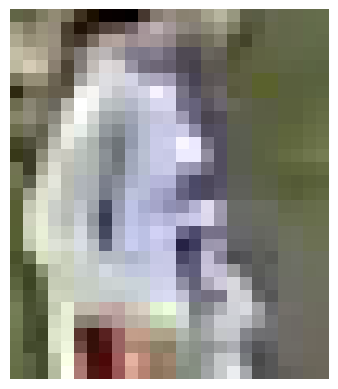

In [52]:
plt.imshow(roi_crops[0])
plt.axis('off')
plt.show()

### Experiment 1: Testing different color formats to kmeans a grass mask.

**Normalized RGB**

Not good enough. The dark parts of the uniform are being masked-out, preventing an accurate team separation

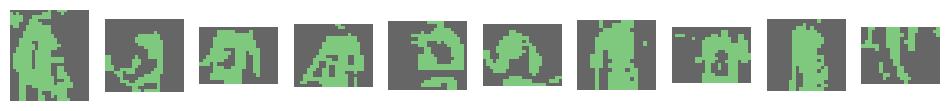

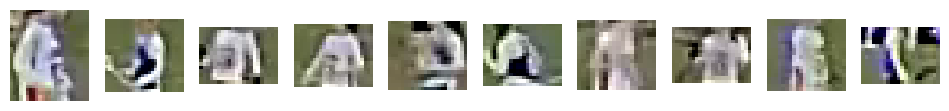

In [57]:
flat_crop_norm = flat_crop_norm_backup.copy()
kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

roi_for_plot_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in roi_crops]
sv.plot_images_grid(roi_for_plot_bgr[:10], grid_size=(1, 10))

**HSV**

Same results as before.

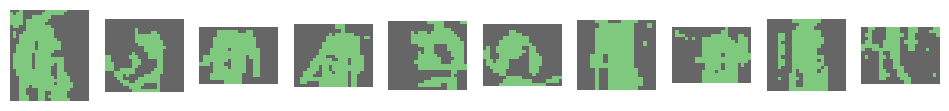

In [41]:
crops = crops_for_team_id_bakup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
roi_crops_hue = [cv2.cvtColor(crop, cv2.COLOR_BGR2HSV) for crop in roi_crops]
shapes = []
flat_crop_array = []
for crop in roi_crops_hue:
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop_array.append(flat_crop)
flat_crop_np = np.concatenate(flat_crop_array, axis=0)


kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_np)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

**LAB**

Same as before.

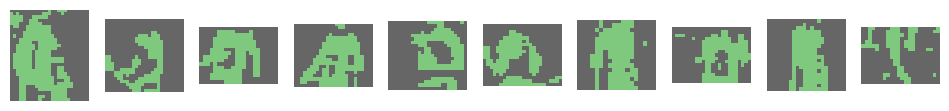

In [42]:
crops = crops_for_team_id_bakup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
roi_crops_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2LAB) for crop in roi_crops]
shapes = []
flat_crop_array = []
for crop in roi_crops_lab:
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop_array.append(flat_crop)
flat_crop_np = np.concatenate(flat_crop_array, axis=0)


kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_np)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

Verifying that the resulting masked colors really don't work.

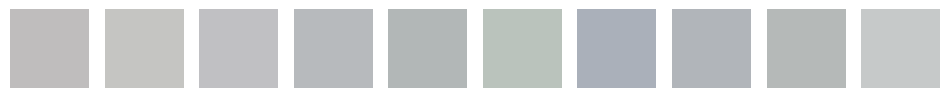

In [59]:
pic = masked_crops[0].copy()
edge_colors = [pic[0, 0], pic[0, -1], pic[-1, 0], pic[-1, -1]]
background_cluster = max(set(edge_colors), key=edge_colors.count)
player_img_cluster = 1 - background_cluster
crops_mean_color = []
for crop, masked_crop in zip(roi_crops, masked_crops):
    mean_color = np.mean(crop[masked_crop == player_img_cluster], axis=0).astype(np.uint8)
    mean_color = cv2.cvtColor(mean_color.reshape(1, 1, 3), cv2.COLOR_BGR2RGB)
    crops_mean_color.append(mean_color.reshape(3))

color_patches = [np.full((50, 50, 3), color, dtype=np.uint8) for color in crops_mean_color[:10]]
color_patches = [cv2.cvtColor(patch, cv2.COLOR_RGB2BGR) for patch in color_patches]
sv.plot_images_grid(color_patches, grid_size=(1, 10))

### Experiment 2: Calculating the grass color and filtering it out.

**Grass Color Extraction**

Gathering crops

Gathering crops for grass color: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


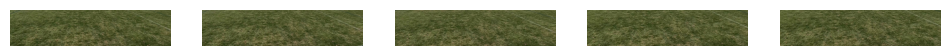

In [10]:
stride = frame_target // 5
crops_for_grass_color: List[np.ndarray] = []

frame_generator_for_grass_color = sv.get_video_frames_generator(stride=stride, **generator_params)

n_frames_for_grass_color = frame_target // stride if stride > 0 else frame_target
for frame in tqdm(frame_generator_for_grass_color, desc="Gathering crops for grass color", total=n_frames_for_grass_color):
    #removing the top 50% of the frame to avoid sky and the bottom 10% to avoid expectators
    crop = frame[int(frame.shape[0]*0.5):int(frame.shape[0]*0.9), :, :]
    crops_for_grass_color.append(crop)

sv.plot_images_grid(crops_for_grass_color, grid_size=(1, 5))


Calculating grass color mean and standard deviation using LAB.

Grass mean color: [ 94 118 150]
Grass std color: [33  1  2]
Grass mean color in RGB: [83 90 50]


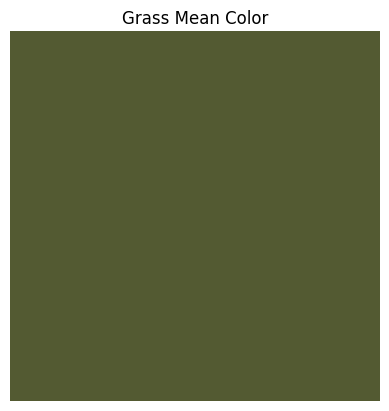

In [11]:
crops_for_grass_color_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2Lab) for crop in crops_for_grass_color]
crops_for_grass_color_lab = [crop.reshape(-1, 3) for crop in crops_for_grass_color_lab]
grass_flat_lab = np.concatenate(crops_for_grass_color_lab, axis=0)
grass_mean_color_lab = np.mean(grass_flat_lab, axis=0).astype(np.uint8)
grass_std_color_lab = np.std(grass_flat_lab, axis=0).astype(np.uint8)
print(f"Grass mean color: {grass_mean_color_lab}")
print(f"Grass std color: {grass_std_color_lab}")

grass_mean_color_rgb = cv2.cvtColor(grass_mean_color_lab.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
print(f"Grass mean color in RGB: {grass_mean_color_rgb}")

color_patch = np.full((5, 5, 3), grass_mean_color_rgb, dtype=np.uint8)
plt.imshow(color_patch)
plt.title("Grass Mean Color")
plt.axis('off')
plt.show()


**Removing colors within one standard deviation**

(3, 3)


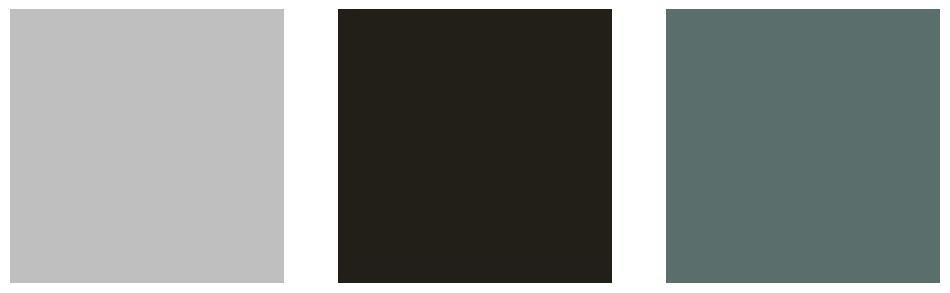

In [32]:
flat_crop_norm = flat_crop_norm_backup.copy()
t_kmeans = KMeans(n_clusters=3, random_state=42)
t_teams = t_kmeans.fit_predict(flat_crop_norm)
centroids = t_kmeans.cluster_centers_
print(centroids.shape)
t_centroid_patchs = [np.full((5, 5, 3), color*255, dtype=np.uint8) for color in centroids[:3]]
sv.plot_images_grid(t_centroid_patchs, grid_size=(1, 3))

In [ ]:
team_kmeans = KMeans(n_clusters=2, random_state=42)
team_labels = team_kmeans.fit_predict(crops_mean_color)

roi_crops_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2Lab) for crop in roi_crops]
masks = [masked_crops[i] == player_img_cluster for i in range(len(masked_crops))]
# masks = [np.expand_dims(m, axis=-1) for m in masks]  # Expand dimensions to match crop shape
roi_crops_lab_masked = [cv2.bitwise_and(crop, crop, mask=mask.astype(np.uint8)) for crop, mask in zip(roi_crops_lab, masks)]
team_0_crops = [roi_crops_lab_masked[i] for i in range(len(roi_crops)) if team_labels[i] == 0]
team_1_crops = [roi_crops_lab_masked[i] for i in range(len(roi_crops)) if team_labels[i] == 1]
crops_for_team_id_rgb = [cv2.cvtColor(crop, cv2.COLOR_BGR2RGB) for crop in crops_for_team_id_bakup]
sv.plot_images_grid(crops_for_team_id_rgb[:10], grid_size=(1, 10))
sv.plot_images_grid(roi_crops_rgb[:10], grid_size=(1, 10))
sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

Generating embeddings: 100%|██████████| 53/53 [00:31<00:00,  1.67it/s]


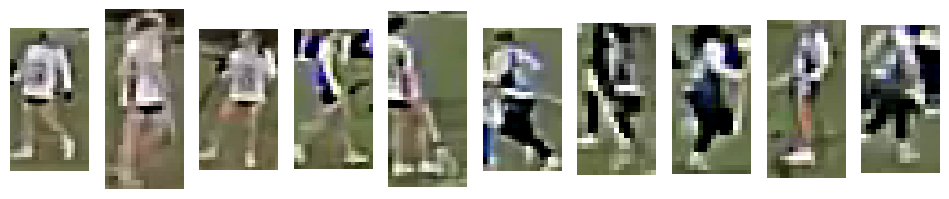

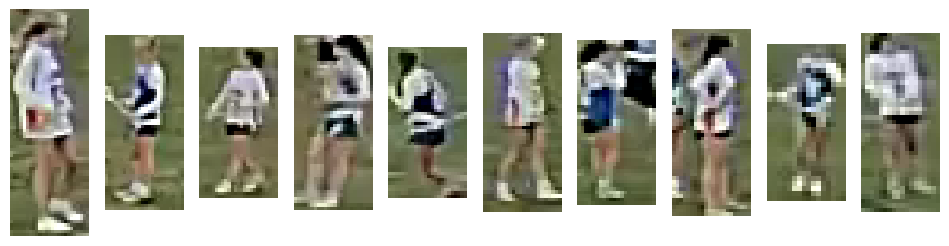

In [25]:
siglip = SiglipReID()

crops_for_team_id_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in crops_for_team_id_rgb]  # Convert to BGR for OpenCV compatibility

embs = siglip.get_emb_from_crops(crops=crops_for_team_id_bgr)

sig_kmeans = KMeans(n_clusters=2, random_state=42)
sig_teams = sig_kmeans.fit_predict(embs)

sig_team_0 = [crops_for_team_id_rgb[i] for i in range(len(crops_for_team_id_rgb)) if sig_teams[i] == 0]
sig_team_1 = [crops_for_team_id_rgb[i] for i in range(len(crops_for_team_id_rgb)) if sig_teams[i] == 1]
sv.plot_images_grid(sig_team_0[:10], grid_size=(1, 10))
sv.plot_images_grid(sig_team_1[:10], grid_size=(1, 10))


In [ ]:
team_array = []
for crop in crops:
    crop = crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :]
    print (crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop = flat_crop.astype(np.float32)
    flat_crop_norm = flat_crop / 255.0
    c_kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = c_kmeans.fit_predict(flat_crop_norm)
    masked_crop = clusters.reshape(crop.shape[0], crop.shape[1])
    print(f"masked_crop shape: {masked_crop.shape}")
    corner_clusters = [masked_crop[0, 0], masked_crop[0, -1], masked_crop[-1, 0], masked_crop[-1, -1]]
    background_cluster = max(set(corner_clusters), key=corner_clusters.count)
    player_cluster = 1 - background_cluster  # Assuming two clusters, one is background
    jersey_color = c_kmeans.cluster_centers_[player_cluster]*255
    jersey_color = (jersey_color).astype(np.float32)
    jersey_color = jersey_color.reshape(1, -1)  # Reshape for prediction
    print (jersey_color)
    break
    team = kmeans.predict(jersey_color)
    team_array.append(team)
team_0_count = team_array.count(0)
team_1_count = team_array.count(1)
print(f"Team 0 count: {team_0_count}, Team 1 count: {team_1_count}")


In [ ]:
crop = crops[0]
crop = crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :]
flat_crop = crop.reshape(-1, 3)
flat_crop = flat_crop
flat_crop_norm = flat_crop 
flat_crop_norm = flat_crop_norm[~np.all(flat_crop_norm == 0, axis=1)]
#flat_crop_norm += 1e-7
print(f"flat_crop_norm shape: {flat_crop_norm.shape}")
c_kmeans = KMeans(n_clusters=2, random_state=42)
print(flat_crop_norm.min(), flat_crop_norm.max())
clusters = c_kmeans.fit_predict(flat_crop_norm)

plt.figure(figsize=(6, 6))
plt.imshow(crop)
plt.tight_layout()
plt.show()

In [ ]:
corner_clusters = [mask[0, 0], mask[0, -1], mask[-1, 0], mask[-1, -1]]
background_cluster = max(set(corner_clusters), key=corner_clusters.count)
print(f"Background cluster: {background_cluster}")

In [ ]:
player_cluster = 1 - background_cluster  # Assuming two clusters, one is background
kmeans.cluster_centers_[player_cluster]*255

In [ ]:
import cv2
import matplotlib.pyplot as plt

crops_for_team_id = crops_for_team_id_bakup.copy()
processed_crops = []

# For OpenCV LAB:
# L: 0-255 (lightness)
# a: 0-255 (green to red, with 128 being neutral)
# b: 0-255 (blue to yellow, with 128 being neutral)

# Define LAB bounds for grass manually - these are more restrictive on the 'a' channel
# which is crucial for isolating green colors in LAB space
# In LAB, lower a values (< 128) represent green colors

# Using LAB color space for segmentation with OpenCV-compatible values
for crop in tqdm(crops_for_team_id, desc="Identifying teams"):
    # The crops are in RGB format
    image_rgb = crop.copy()
    
    # Convert RGB to BGR (OpenCV standard)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    
    # Convert BGR to LAB (OpenCV handles conversion directly)
    lab_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    
    # Create mask for grass areas using manually tuned LAB bounds
    # Focus on 'a' channel to isolate grass green color
    grass_mask = cv2.inRange(lab_image, DEFAULT_LOWER_LAB_GRASS, DEFAULT_UPPER_LAB_GRASS)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    grass_mask = cv2.morphologyEx(grass_mask, cv2.MORPH_OPEN, kernel)
    grass_mask = cv2.morphologyEx(grass_mask, cv2.MORPH_CLOSE, kernel)
    
    # Invert the mask to keep the player and remove grass
    # This will be 255 (white) for players, 0 (black) for grass
    player_mask = cv2.bitwise_not(grass_mask)
    
    # Apply the mask directly to the original RGB image
    # Where mask is 0, the output will be black
    # Keep the result in RGB format for consistency
    masked_image_rgb = cv2.bitwise_and(image_rgb, image_rgb, mask=player_mask)
    
    processed_crops.append(masked_image_rgb)

# Display a sample of original and masked images to verify results
if len(crops_for_team_id) > 0:
    fig, axes = plt.subplots(5, 4, figsize=(15, 18))
    axes = axes.flatten()
    
    for i in range(min(10, len(crops_for_team_id))):
        # Original image
        axes[i*2].imshow(crops_for_team_id[i])
        axes[i*2].set_title(f"Original {i+1}")
        axes[i*2].axis('off')
        
        # Masked image
        axes[i*2+1].imshow(processed_crops[i])
        axes[i*2+1].set_title(f"Masked {i+1}")
        axes[i*2+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print the manually tuned LAB bounds
    print(f"Manual LAB bounds used for grass segmentation:")
    print(f"Lower LAB: {DEFAULT_LOWER_LAB_GRASS}")
    print(f"Upper LAB: {DEFAULT_UPPER_LAB_GRASS}")

crops_for_team_id = processed_crops.copy()

In [ ]:
emb_for_id = emb_provider.get_emb_from_crops(crops_for_team_id)
team_identifier.train_team_identification(emb_for_id)

In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [ ]:
projections = REDUCER.fit_transform(emb_for_id)
clusters = CLUSTERING_MODEL.fit_predict(projections)
crops = [sv.cv2_to_pillow(crop) for crop in crops_for_team_id]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projections[:, 0], projections[:, 1], projections[:, 2], c=clusters, cmap='coolwarm', s=10)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
ax.set_title('3D UMAP Projection of Player Embeddings')
plt.show()

In [ ]:
teams = team_identifier.predict_team(emb_for_id)

mask = teams == 0
crops_team = [cv2.cvtColor(crop, cv2.COLOR_BGR2RGB) for crop, keep in zip(crops_for_team_id_bakup, mask) if keep]
crops_team = [crop for crop in crops_team if crop.shape[0] > 40 and crop.shape[1] > 18]  # Ensure crops are valid
sv.plot_images_grid(crops_team[:100], grid_size=(10, 10))

In [ ]:
import numpy as np

heights = [h for h, w in crop_shapes]
widths = [w for h, w in crop_shapes]

h_9th_decile = np.percentile(heights, 10)
w_9th_decile = np.percentile(widths, 10)

print(f"9th decile (90th percentile) of crop height: {h_9th_decile}")
print(f"9th decile (90th percentile) of crop width: {w_9th_decile}")

In [ ]:
crop_shapes = [(crop.shape[0], crop.shape[1]) for crop in crops_for_team_id_bakup]
print(crop_shapes[:100])  # Show the height and width of the first 10 crops

In [ ]:
frames_generator = sv.get_video_frames_generator(**generator_params)
previous_frame = None
affine_matrix = None

tracker_team_0 = AffineAwareByteTrack()
tracker_team_1 = AffineAwareByteTrack()

for frame in tqdm(frames_generator, desc="Frames read", total=frame_target):
    all_detections = model.generate_detections(frame)
    # all_detections = all_detections.with_nms(threshold=0.9, class_agnostic=True)

    # Affine matrix determines any camera move between consecutive frames (very important)
    if previous_frame is not None:
        affine_matrix = AffineAwareByteTrack.calculate_affine_transform(previous_frame, frame)
    if affine_matrix is None:
        affine_matrix = AffineAwareByteTrack.get_identity_affine_matrix()

    player_detections = all_detections[all_detections.class_id == _PLAYER_CLASS_ID]
    player_crops = [sv.crop_image(frame, xyxy=bbox) for bbox in player_detections.xyxy]
    player_embeddings = emb_provider.get_emb_from_crops(player_crops)
    player_teams = team_identifier.predict_team(player_embeddings)

    mask = player_teams == 0

    detections_team_0 = player_detections[mask]
    detections_team_1 = player_detections[~mask]

    detections_team_0.class_id = np.full_like(detections_team_0.class_id, 30, dtype=np.int8)
    detections_team_1.class_id = np.full_like(detections_team_1.class_id, 31, dtype=np.int8)

    detections_team_0 = tracker_team_0.update_with_transform(detections_team_0, affine_matrix, frame=frame.copy())
    detections_team_1 = tracker_team_1.update_with_transform(detections_team_1, affine_matrix, frame=frame.copy())

    previous_frame = frame.copy()
        
    multi_frame_detections.append((detections_team_0, detections_team_1))
    multi_ineligible_track_ids_team_0.append(tracker_team_0.get_tids_for_frame())
    multi_ineligible_track_ids_team_1.append(tracker_team_1.get_tids_for_frame())

In [ ]:
multi_frame_detections_bak = multi_frame_detections.copy()

In [ ]:
multi_frame_detections = multi_frame_detections_bak.copy()
frames_generator = sv.get_video_frames_generator(**generator_params)
with sv.VideoSink(target_path="results.mp4", video_info=video_info) as sink:
    for frame in tqdm(frames_generator, desc="Writing frames", total=frame_target):
       
        detections_team_0, detections_team_1 = multi_frame_detections.popleft()

        detections = sv.Detections(
            xyxy=np.concatenate([detections_team_0.xyxy, detections_team_1.xyxy]),
            confidence=np.concatenate([detections_team_0.confidence, detections_team_1.confidence]),
            class_id=np.concatenate([detections_team_0.class_id, detections_team_1.class_id]),
            tracker_id=np.concatenate([detections_team_0.tracker_id, detections_team_1.tracker_id])
        )

        annotated_frame = ellipse_annotator.annotate(
            scene=frame.copy(),
            detections=detections,
        )

        labels = [str(tid) for tid in detections.tracker_id]

        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels,
        )
        sink.write_frame(frame=annotated_frame)


In [ ]:
sv.plot_images_grid(processed_crops[:100], grid_size=(10, 10))